In [10]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

# https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

12089


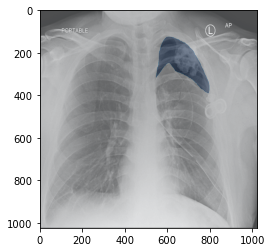

In [81]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
file_ImageId_path = []
for root, dir_, files in os.walk("dicom-images-train"):
    for file in files:
        if file.endswith(".dcm"):
            file_ImageId_path.append([os.path.splitext(file)[0], os.path.join(root, file)])
print(len(file_ImageId_path))           
# df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])

df_files = pd.DataFrame(file_ImageId_path, columns=["ImageId", "filepath"])
df_files
df_siim = pd.read_csv("train-rle.csv")
df_siim_file = pd.merge(df_siim, df_files, on="ImageId")
case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[1]]
dcm = pydicom.dcmread(case1.filepath.values.tolist()[0])
img = dcm.pixel_array
height, width = img.shape
mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0], width, height)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.3)

544
125
----
796
391


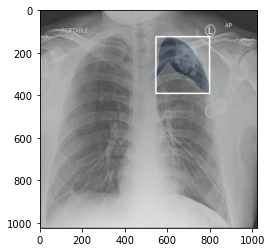

502
101
----
628
169


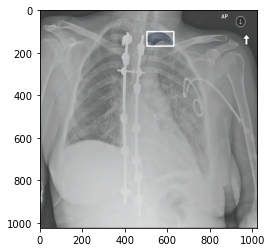

578
177
----
986
835


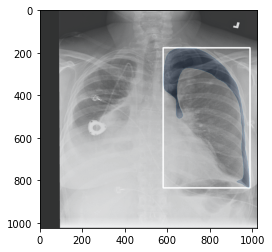

In [54]:
from pydicom import dcmread
from pydicom.data import get_testdata_files
from skimage.measure import label, regionprops
import cv2

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


for i in range(5):
    
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    height, width = img.shape
    
    
    if not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        
    
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask) 
        props = regionprops(lbl_0)
        for prop in props:
            print(prop.bbox[1])
            print(prop.bbox[0])
            print('----')
            print(prop.bbox[3])
            print(prop.bbox[2])
            cv2.rectangle(img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 255, 255), 5)
            
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
#             print(bb)
#             x = bb[0]
#             y = bb[1]
#             w = bb[2]
#             h = bb[3]
#             dw = 1024
#             dh = 1024
            
#             l = int((x - w / 2) * dw)
#             r = int((x + w / 2) * dw)
#             t = int((y - h / 2) * dh)
#             b = int((y + h / 2) * dh)
            
#             if l < 0:
#                 l = 0
#             if r > dw - 1:
#                 r = dw - 1
#             if t < 0:
#                 t = 0
#             if b > dh - 1:
#                 b = dh - 1

#             cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

        
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='Blues', alpha=0.2)
        plt.show()

# prepare data for yolo
- images: dicom to jpg
- annotations: cover bounding box to yolo formate

In [109]:
dicom_path = './dicom-images-train'
save_jpg_path = './images'
annotations_path ='./annotations'

def convert_boundingbox_to_yolo_formate(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

# for i in range(10):
for i in range(len(df_siim_file['ImageId'])):
    
    # jpg
    case1 = df_siim_file[df_siim_file.ImageId==df_siim_file.ImageId.values.tolist()[i]]
    dcm = dcmread(case1.filepath.values.tolist()[0])
    img = dcm.pixel_array
    cv2.imwrite(os.path.join(save_jpg_path,df_siim_file['ImageId'][i]+'.jpg'), img)
    
    
    # label
    if (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        with open(os.path.join(annotations_path,df_siim_file['ImageId'][i]+'.txt'),'w') as f:
            pass
        
    elif not (case1[' EncodedPixels'].values.tolist()[0]) == str(-1):
        mask = rle2mask(case1[' EncodedPixels'].values.tolist()[0],  height, width)
        lbl_0 = label(mask) 
        props = regionprops(lbl_0)
        for prop in props:
            b = (prop.bbox[1], prop.bbox[3], prop.bbox[0], prop.bbox[2])
            bb = convert_boundingbox_to_yolo_formate((1024,1024), b)
            
            with open(os.path.join(annotations_path,df_siim_file['ImageId'][i]+'.txt'),'w') as f:
                f.write('0'+'\t'+str(bb[0])+'\t'+str(bb[1])+'\t'+str(bb[2])+'\t'+str(bb[3])+'\t')
                f.close()
    
#     break
    

(125, 544, 391, 796)
(101, 502, 169, 628)
(177, 578, 835, 986)


# 檢查一張圖片兩處氣胸